This tutorial covers:
1. Loading Spatial Transcriptomics (ST) data and doing some basic pre-processing
2. Plotting expression of a gene or gene module with `embed_geneset`
3. Plotting expression of two genes or gene modules on the same embedding with `embed_bivariate_genes`
4. Transforming coordinates with `flip_coordinates` and `rotate_coordinates`
5. Defining regions based on gradients or contours of gene or gene module expression with `contourize`
6. Defining genes that vary in expression or that have spatially localized expression
7. Finding genes that have expression patterns that match a user-specified gene with `find_similar_genes`

### Load required packages

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import pySingleCellNet as cn
import squidpy as sq
import stuf as uf

/opt/homebrew/Caskroom/miniforge/base/envs/stuf_docs/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/homebrew/Caskroom/miniforge/base/envs/stuf_docs/lib/python3.12/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [2]:
plt.rcParams['figure.dpi'] = 100
spot_size = 5

### Load and pre-process ST data
The data that we use here is described in the example_data page. In brief, it is from mouse embryos at stage E11.5, from the trunk immediately adjacent to the forelimb.

Below, we are using the file __Demo_3__. You must download this data and adjust the call to ```sc.read_h5ad()``` below according to where you saved the data file.

In [3]:
adata = sc.read_h5ad("E11_demo_3_072625.h5ad")
adx = adata.copy()

Although the ST data has been cleaned of spots/cells that have low counts, we still can filter out genes that are detected in very few spots.

In [4]:
min_cells = 10
sc.pp.filter_genes(adx, min_cells=min_cells)

We do not perform a library-size normalization but only log1p transform the data.

In [5]:
adx.layers['counts'] = adx.X.copy()
sc.pp.log1p(adx)

### Plotting a gene or gene module
The function ```embed_geneset()``` to shows the expression of a gene based on the embedding, or cell coordinates, specified by the `embedding_key` parameter (which defaults to "X_spatial"). We can also use this function to display the aggregated expression of a list of genes. First, let's just look at Sox2, which is highly expressed in neural progenitor cells of the ventricular zone.

<Axes: >

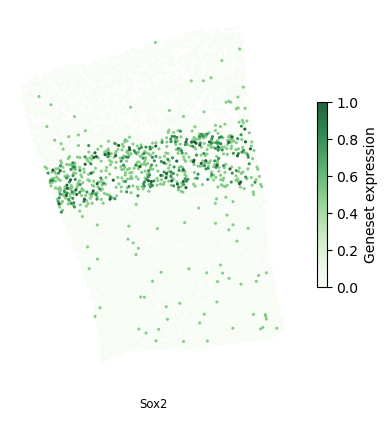

In [6]:
gene = "Sox2"
uf.pl.embed_geneset(
        adx,
        genes=[gene],
        scatter_kwargs={'s': spot_size, 'cmap': 'Greens'})

Now let's look at Tubb3, which is highly expressed cells that have exited cell cycle, and have migrated away from the ventricular zone into the mantle.

<Axes: >

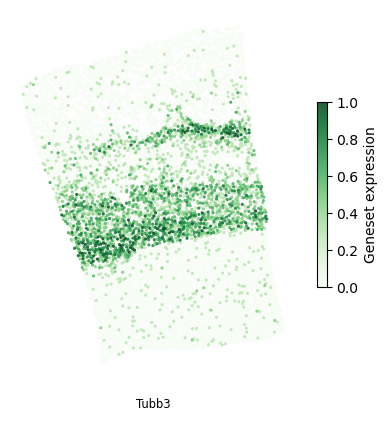

In [7]:
gene = "Tubb3"
uf.pl.embed_geneset(
        adx,
        genes=[gene],
        scatter_kwargs={'s': spot_size, 'cmap': 'Greens'})

What does the aggregated expression of ventricular or mantle genes look like? I really know nothing about neural development so would not be able to guess what other genes are ventricular vs mantle. However, we can compile such lists from [this nice paper by Delile et al 2019 from the labs of James Biscoe and Andreas Sagner](https://journals.biologists.com/dev/article/146/12/dev173807/19473/Single-cell-transcriptomics-reveals-spatial-and). Below, we define two gene lists. Then, for each, we compute and plot the aggregated expression of all genes in each list. We use Matplotlib's `subplots()` to display the plots side-by-side.

Text(0.5, 1.0, 'Mantle geneset')

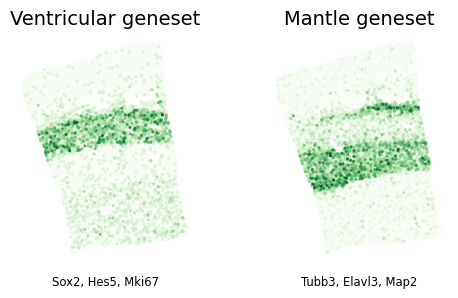

In [8]:
gl_npc = ["Sox2", "Hes5", "Mki67"]
gl_mantle = ["Tubb3", "Elavl3", "Map2"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,3))

uf.pl.embed_geneset(adx,
    genes=gl_npc,
    ax=ax1,
    log1p=False,
    show_colorbar=False,
    show_gene_names=True,
    scatter_kwargs={'s': spot_size, 'cmap': 'Greens'}
)
ax1.set_title("Ventricular geneset", fontsize=14)

uf.pl.embed_geneset(adx,
    genes=gl_mantle,
    ax=ax2,
    log1p=False,
    show_colorbar=False,
    show_gene_names=True,
    scatter_kwargs={'s': spot_size, 'cmap': 'Greens'}
)
ax2.set_title("Mantle geneset", fontsize=14)

Later we will explore other ways to explore gene sets from other sources, and to generate gene signatures or modules de novo from our data.

### Bivariate plots
It would be interesting to see precisely where there is exclusive ventricular signal vs mantle signal, and where they overlap. We will use the `embed_bivariate_genes` function to do this.

<Axes: >

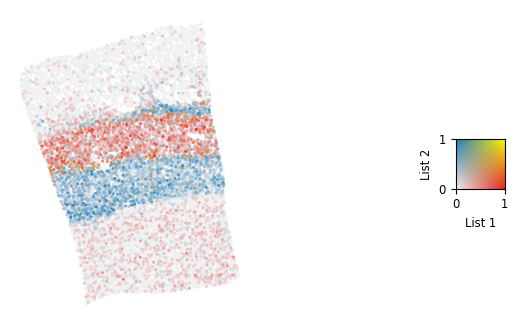

In [9]:
uf.pl.embed_bivariate_genes(adx,
    genes1=gl_npc, genes2=gl_mantle,
    scatter_kwargs={'s':spot_size},
    show_legend=True,
    clip_percentiles=(0,99),
    list_genes=False,
)

Spots are colored according to expression of _both_ gene sets, as indicated with the color square. So, red and blue indicate high ventricular or mantle only, respectfully. Yellow indicates high expression of both gene sets, and grey indicates low-to-no expression of either gene set.

`embed_bivariate_genes` is useful when you want to resolve localized expression of sets of genes. Below, we highlight the relative location of mantle sub-populations.

In [10]:
gl_dorsalish = ["Bhlhe22", "Pax2", "Pax8", "Lbx1"]
gl_ventralish = ["Isl2", "Isl1"]

<Axes: >

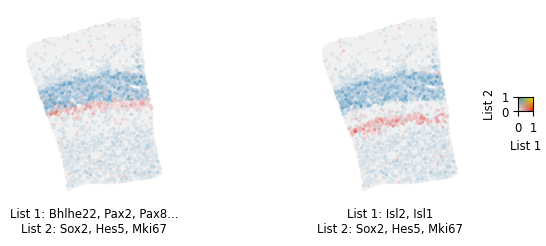

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7,3))

uf.pl.embed_bivariate_genes(adx,                    
    genes1=gl_dorsalish, genes2=gl_npc, 
    ax = ax1,
    scatter_kwargs={'s':spot_size},
    show_legend=False,
    clip_percentiles=(0,100),
    list_genes=True,
)

uf.pl.embed_bivariate_genes(adx,
    genes1=gl_ventralish, genes2=gl_npc,
    ax = ax2,
    scatter_kwargs={'s':spot_size},
    show_legend=True,
    clip_percentiles=(0,100),
    list_genes=True,
    cbar_kwargs={'width':'10%','height':'80%','loc':'center right', 'borderpad':-5}
)


### Flip and rotate
It is easy to flip or rotate a section. You might want to do this so that your section is aligned with a body plan axis. In our example data, in the neural tube Hoxc9 is expressed posteriorly whereas Hoxc6 is expressed more anteriorly (but also more broadly across the entire section), so we can use these two genes to orient our section.

<Axes: >

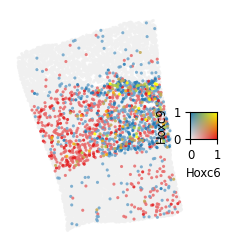

In [12]:
fig, ax1 = plt.subplots(1, 1, figsize=(3,3))

uf.pl.embed_bivariate_genes(adx,
    genes1=["Hoxc6"], genes2=["Hoxc9"],
    ax = ax1,
    scatter_kwargs={'s':spot_size},
    show_legend=True,
    clip_percentiles=(0,99),
    list_genes=False,
    cbar_kwargs={'width':'15%','height':'80%','loc':'center right', 'borderpad':-2}
)

We want the anterior end at the top, so let's rotate the section 100 degrees clockwise.

In [13]:
uf.ut.rotate_coordinates(adx, "X_spatial", 100)

Below, we use subplots to better position the colorbox legend. 

<Axes: >

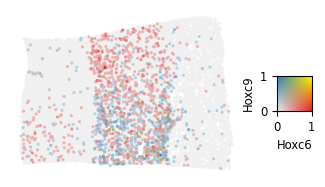

In [14]:
fig, ax1 = plt.subplots(1, 1, figsize=(3,3))

uf.pl.embed_bivariate_genes(adx,
    genes1=["Hoxc6"], genes2=["Hoxc9"],
    ax = ax1,
    scatter_kwargs={'s':spot_size},
    show_legend=True,
    clip_percentiles=(0,100),
    list_genes=False,
    cbar_kwargs={'width':'15%','height':'80%','loc':'center right', 'borderpad':-5}
)

### Contours
Suppose that you wanted to find other genes that are differenitally expressed between the proliferating ventricular zone and the mantle. How would you define cells that belong to each region? A simple approach that takes advantage of spatial information is to split the section into contours defined by their expression of a gene or gene set. The very cool [GASTON method does this with deep learning](https://www.nature.com/articles/s41592-024-02503-3]), which is very powerful but also somewhat time-consuming to train. STUF's `contourize` function simply assigns spots/cells to a bin based on expression of a specified gene or gene set, and applies smoothing and spatial constraints to derive a final contour map. Here, we use this approach to define ventricular and mantle regions.

In [15]:
ad3 = adx.copy()
kname = "contour_ventricular"
uf.tl.contourize(ad3,genes=gl_npc, contour_levels=3,spatial_key="X_spatial",grid_res=200, log_transform=False, clip_percentiles=(0,100), annotation_key=kname, smooth_sigma=4)

Now, let's compare the ventricular gene set expression to the contours. To plot the latter, we will use the `embed_categorical()` function.

Text(0.5, 1.0, 'Contours of ventricular zone')

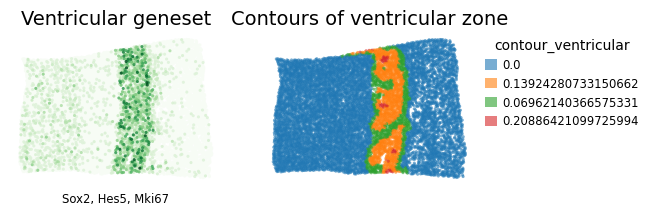

In [16]:
ssize = 5
fig, (ax_expr, ax_cat) = plt.subplots(1, 2, figsize=(6, 3))

uf.pl.embed_geneset(ad3, genes = gl_npc, embedding_key='X_spatial', scatter_kwargs={'s':ssize, 'cmap':'Greens'}, ax=ax_expr,  show_colorbar=False)
ax_expr.set_title("Ventricular geneset", fontsize=14)
uf.pl.embed_categorical(ad3, category_key = kname, embedding_key='X_spatial', scatter_kwargs={'s':ssize}, ax=ax_cat, show_legend=True)
ax_cat.set_title("Contours of ventricular zone", fontsize=14)


Let's do the same thing but for the mantle.

In [17]:
kname = "contour_mantle"
uf.tl.contourize(ad3,genes=gl_mantle, contour_levels=3,spatial_key="X_spatial",grid_res=200, log_transform=False, clip_percentiles=(0,100), annotation_key=kname, smooth_sigma=4)

Text(0.5, 1.0, 'Contours of mantle zone')

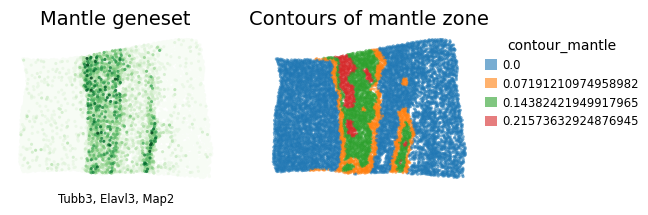

In [18]:
ssize = 5
fig, (ax_expr, ax_cat) = plt.subplots(1, 2, figsize=(6, 3))

uf.pl.embed_geneset(ad3, genes = gl_mantle, embedding_key='X_spatial', scatter_kwargs={'s':ssize, 'cmap':'Greens'}, ax=ax_expr,  show_colorbar=False)
ax_expr.set_title("Mantle geneset", fontsize=14)
uf.pl.embed_categorical(ad3, category_key = kname, embedding_key='X_spatial', scatter_kwargs={'s':ssize}, ax=ax_cat, show_legend=True)
ax_cat.set_title("Contours of mantle zone", fontsize=14)


Now we assign cells/spots to annotated regions. First, we set geneset-specific contour thresholds, and then apply them to the adata to generate a new .obs annotation column that we name 'contour_ann'.

In [19]:
rules = {
    'contour_ventricular':{
        'threshold': 0.07,
        'annotation': 'Ventricular'},
    'contour_mantle':{
        'threshold': 0.08,
        'annotation': 'Mantle'},       
}

adx2 = uf.tl.annotate_obs_by_threshold_combined(ad3, rules, new_col='contour_ann')

adx2.obs['contour_ann'].value_counts()


contour_ann
                      6456
Mantle                1755
Ventricular           1162
Ventricular_Mantle      45
Name: count, dtype: int64

<Axes: >

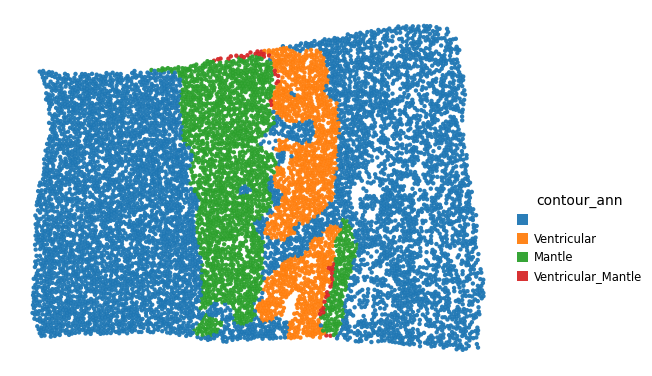

In [20]:
uf.pl.embed_categorical(adx2, category_key = 'contour_ann', embedding_key='X_spatial', scatter_kwargs={'s':10, 'edgecolors':'none','linewidths':0, 'alpha':0.95},legend_kwargs={'loc':'upper left','bbox_to_anchor':(1.01, 0.5), "ncol":1})

Now use scanpy's `rank_genes_groups` function to compare Ventricular vs Mantle

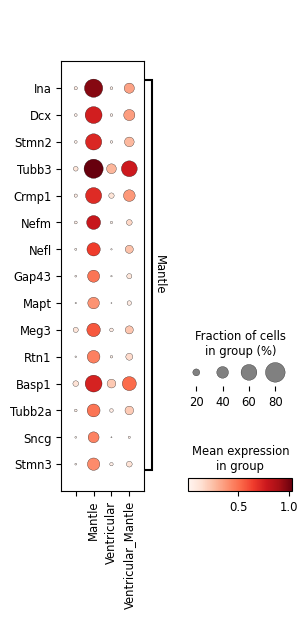

In [21]:
sc.tl.rank_genes_groups(adx2, groupby='contour_ann', groups = ["Mantle"], reference = "Ventricular")
sc.pl.rank_genes_groups_dotplot(adx2, n_genes=15, groupby='contour_ann',  key='rank_genes_groups', swap_axes=True, dendrogram=False)

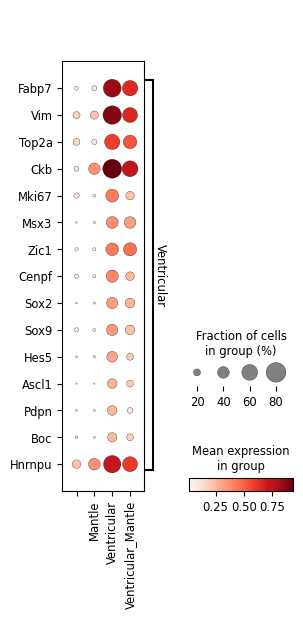

In [22]:
sc.tl.rank_genes_groups(adx2, groupby='contour_ann', groups = ["Ventricular"], reference = "Mantle" )
sc.pl.rank_genes_groups_dotplot(adx2, n_genes=15, groupby='contour_ann',  key='rank_genes_groups', swap_axes=True, dendrogram=False)

### Define variable genes
Often, we already know a few genes that mark specific cell populations or act as tissue landmarks. Sox2 and Tubb3 and such genes in our example data. It can be informative to find other genes that have similar expression patterns as these 'anchor' genes. In this section, we will illustrate how to search for genes that match the expression pattern of a user-specified gene. But first, we need to do some further pre-processing to make down-stream tasks faster. Specifically, we need to identfy highly variable genes and spatially variable genes. We will use standard functions from Scanpy and Squidpy to achieve this goal.

In [23]:
# HVG
sc.pp.highly_variable_genes(adx2, n_top_genes=2000, flavor='cell_ranger')
# SVG
sq.gr.spatial_neighbors(adx2,spatial_key='X_spatial')
sq.gr.spatial_autocorr(adx2, mode="moran")
threshold = 0.25
# annotate_spatially_variable_genes is a help function to add the spatially_variable annotation to .var
uf.ut.annotate_spatially_variable_genes(adx2, pval_column="pval_norm_fdr_bh", pval_cutoff=threshold)


### Find genes that match expression pattern of user-given gene
To achieve this, we compute the kNN of spatially variable genes. Here, we use 1 - correlation coefficient as a distance metric, but other distance metrics can be used.

In [25]:
uf.tl.build_gene_knn_graph(adx2, mask_var='spatially_variable', mean_cluster=False, metric='correlation', knn=10)

We are finally ready to find genes that are most similar to our anchor genes. We will start with Tubb3 and Sox2.

In [26]:
gene = "Tubb3"
gl_tubb3 = uf.tl.find_similar_genes(adx2, gene, 10, use='distances')
print(gl_tubb3)

['Tuba1a', 'Stmn2', 'Ina', 'Dcx', 'Map1b', 'Crmp1', 'Dpysl3', 'Tubb2b', 'Nefl']


In [27]:
gene = "Sox2"
gl_sox2 = uf.tl.find_similar_genes(adx2, gene, 10, use='distances')
print(gl_sox2)

['Fabp7', 'Ckb', 'Vim', 'Msx3', 'Hes5', 'Hoxb9', 'Zic1', 'Fzd10', 'Cenpf']


Let's plot the first 5 per anchor gene.

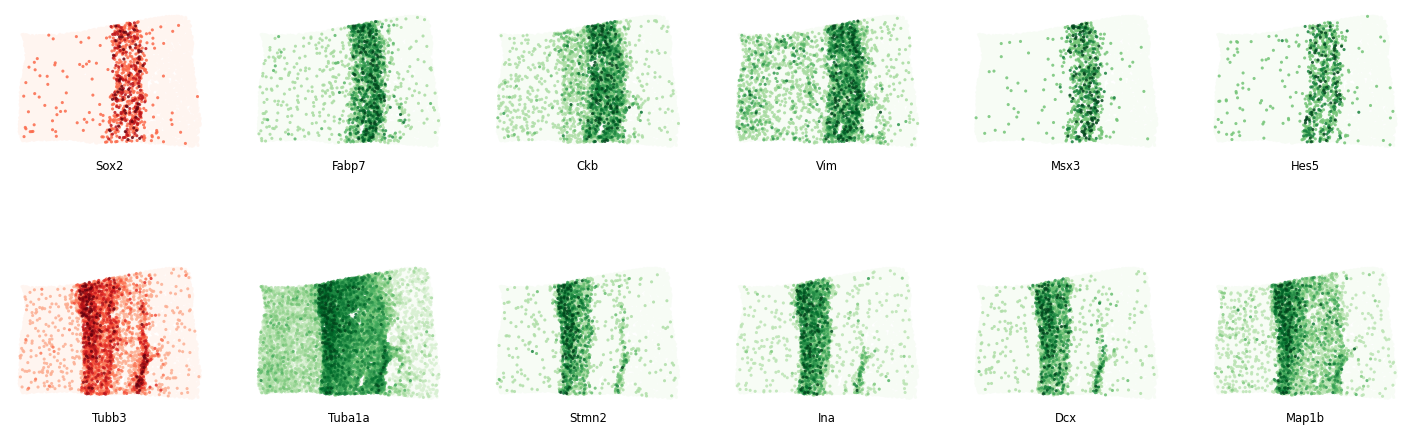

In [28]:
n_cols = 6
n_rows = 2
ngenes = 12

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(n_cols * 3, n_rows * 3),
    squeeze=False
)

# Sox2
uf.pl.embed_geneset(
    adx2,
    genes=["Sox2"],
    ax=axes[0,0],
    show_colorbar=False, 
    show_gene_names=True,
    scatter_kwargs={'s': spot_size, 'cmap': 'Reds'}
)
    
# plot each sox2-like gene 
for ax, gene in zip(axes[0,][1:], gl_sox2[0:6] ):
    uf.pl.embed_geneset(
        adx2,
        genes=[gene],
        ax=ax,
        show_colorbar=False,     
        show_gene_names=True,  
        scatter_kwargs={'s': spot_size, 'cmap': 'Greens'}
    )

# Tubb3
uf.pl.embed_geneset(
    adx2,
    genes=["Tubb3"],
    ax=axes[1,0],
    show_colorbar=False, 
    show_gene_names=True,
    scatter_kwargs={'s': spot_size, 'cmap': 'Reds'}
)
    
# plot each tubb3-like gene
for ax, gene in zip(axes[1,][1:], gl_tubb3[0:6] ):
    uf.pl.embed_geneset(
        adx2,
        genes=[gene],
        ax=ax,
        show_colorbar=False,     
        show_gene_names=True, 
        scatter_kwargs={'s': spot_size, 'cmap': 'Greens'}
    )

Recall earlier when we examined expression of two distinctly patterned mantle genesets (Pax2/Pax8 vs Isl1/Isl2)? Let's see if we can find other genes correlated with these.

In [29]:
gene = "Isl1"
gl_Isl1 = uf.tl.find_similar_genes(adx2, gene, 10, use='distances')
print(gl_Isl1)

['Nefm', 'Nefl', 'Sncg', 'Prph', 'Snhg11', 'Gap43', 'Stmn2', 'Aldh1a2', 'Pfkp']


In [30]:
gene = "Pax8"
gl_pax8 = uf.tl.find_similar_genes(adx2, gene, 10, use='distances')
print(gl_pax8)

['Lhx1', 'Lhx1os', 'Robo3', 'Sst', 'Igfbpl1', 'Gad2', 'Chl1', 'Mir124a-1hg', 'Lamp5']


Now let's see how these genes sets are distributed spatially:

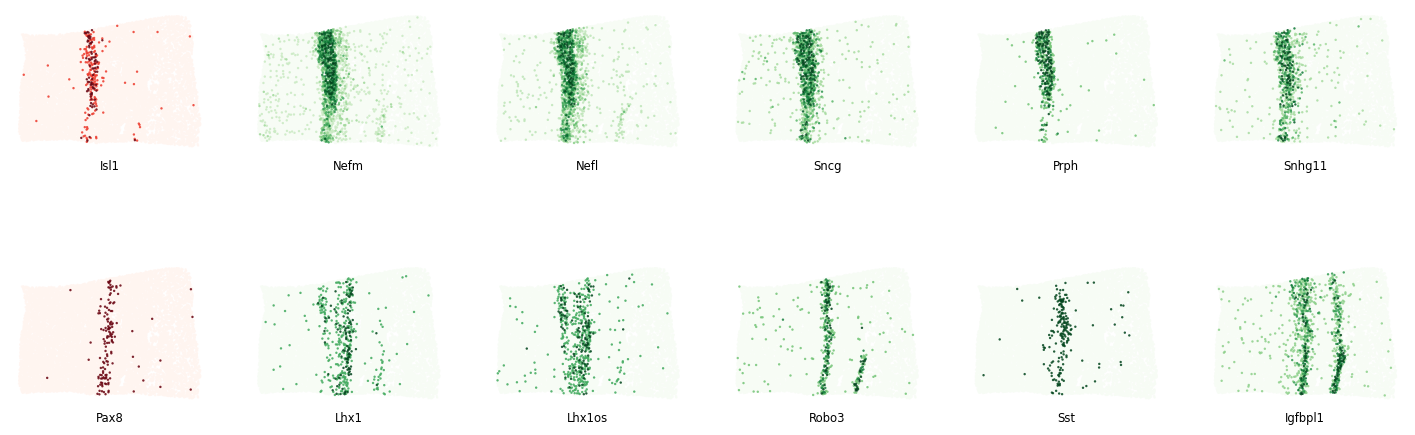

In [31]:
n_cols = 6
n_rows = 2
ngenes = 12
spot_size = 3
fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(n_cols * 3, n_rows * 3),
    squeeze=False
)

# 
uf.pl.embed_geneset(
    adx2,
    genes=["Isl1"],
    ax=axes[0,0],
    show_colorbar=False, 
    show_gene_names=True,
    scatter_kwargs={'s': spot_size, 'cmap': 'Reds'}
)

for ax, gene in zip(axes[0,][1:], gl_Isl1[0:6] ):
    uf.pl.embed_geneset(
        adx2,
        genes=[gene],
        ax=ax,
        show_colorbar=False,     
        show_gene_names=True,  
        scatter_kwargs={'s': spot_size, 'cmap': 'Greens'}
    )

# Pax8
uf.pl.embed_geneset(
    adx2,
    genes=["Pax8"],
    ax=axes[1,0],
    show_colorbar=False, 
    show_gene_names=True,
    scatter_kwargs={'s': spot_size, 'cmap': 'Reds'}
)
    
for ax, gene in zip(axes[1,][1:], gl_pax8[0:6] ):
    uf.pl.embed_geneset(
        adx2,
        genes=[gene],
        ax=ax,
        show_colorbar=False,     
        show_gene_names=True, 
        scatter_kwargs={'s': spot_size, 'cmap': 'Greens'}
    )



The Pax8 list can be refined a bit. I looked at neighbors of Robo3 and found Cntn2 (not shown here)

In [32]:
gl_pax8 = ["Pax8", "Robo3", "Sst", "Igfbpl1", "Cntn2"]

<Axes: >

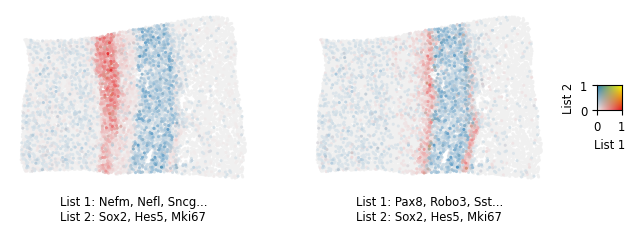

In [33]:
spot_size = 5
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7,3))

uf.pl.embed_bivariate_genes(adx2,                    
    genes1=gl_Isl1 + ["Isl1"], genes2=gl_npc, 
    ax = ax1,
    scatter_kwargs={'s':spot_size, 'alpha':0.95},
    show_legend=False,
    clip_percentiles=(0,100),
    list_genes=True,
)

uf.pl.embed_bivariate_genes(adx2,
    genes1=gl_pax8, genes2=gl_npc,
    ax = ax2,
    scatter_kwargs={'s':spot_size , 'alpha':0.95},
    show_legend=True,
    clip_percentiles=(0,100),
    list_genes=True,
    cbar_kwargs={'width':'10%','height':'80%','loc':'center right', 'borderpad':-5}
)


One more exploratory analysis: Wnt1 is reported to be preferentially expressed in the roof plate. Depending on how the tissue section was prepared, we may or may not be able to detect the roof plate in this data. Let's if any other genes are correlated with Wnt1 and where they are expressed.

In [34]:
gene = "Wnt1"
gl_wnt1 = uf.tl.find_similar_genes(adx2, gene, 10, use='distances')
print(gl_wnt1)

['Fgf15', 'Atoh1', 'Casz1', 'Gdf10', 'Ccdc182', 'Msx1', 'Masp1', 'A930005G22Rik', 'Fgfr2']


In [35]:
gl_wnt1 = ["Wnt1"] + gl_wnt1

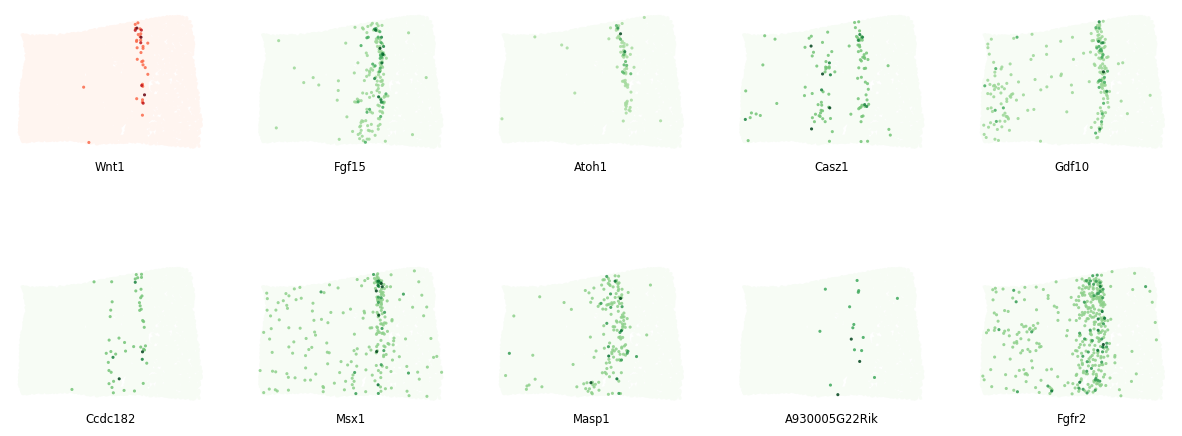

In [36]:
n_cols = 5
n_rows = 2
ngenes = 10

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(n_cols * 3, n_rows * 3),
)

axes_flat = axes.ravel()

for ax, gene in zip(axes_flat, gl_wnt1 ):
    xcolor = "Greens"
    if gene == "Wnt1":
        xcolor = "Reds"
        
    uf.pl.embed_geneset(
        adx2,
        genes=[gene],
        ax=ax,
        show_colorbar=False,     
        show_gene_names=True,  
        clip_percentiles=(0,100),
        scatter_kwargs={'s': spot_size, 'cmap': xcolor}
    )
